In [1]:
!ls ../gen_lightcurves/DES_lcurves/

DES_BLIND+HOSTZ		 des_sn.pkl    proc_DES_fakes.py
DES_BLIND+HOSTZ.tar.gz	 outdiffs.pkl  proc_DES_fakes.pyc
DES_BLINDnoHOSTZ.tar.gz  plot_lc.py    TEST+HOST.KEY


In [2]:
import os
import sys
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as scinterp
sys.path.append('../gen_lightcurves/')
import ANTARES_object

/usr/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-25 15:30:56.726402. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [20]:
base_path = '../gen_lightcurves/DES_lcurves/DES_BLIND+HOSTZ/'
key_file = '../gen_lightcurves/DES_lcurves/TEST+HOST.KEY'
with open(key_file, 'r') as f:
    data = f.readlines()
SN_key = {}
for line in data:
    if line.startswith('NVAR') or line.startswith('VARNAMES'):
        continue
    #Only need 2nd 3rd and 4th element
    _, sn_id, sntype, confirm_type, genz, hostz, hostzerr = line.split()
    SN_key[int(sn_id)] = {'sntype': int(sntype), 'confirm_type': int(confirm_type),\
                     'genz': float(genz), 'hostz': float(hostz), 'hostzerr': float(hostzerr)}
print(len(SN_key.keys()))


18321


{'confirm_type': -9,
 'genz': 0.30168,
 'hostz': 0.36318,
 'hostzerr': 0.0334,
 'sntype': 3}

/usr/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-25 20:20:21.153416. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


18328
Number of obs in g: 6
Number of obs in i: 6
Number of obs in r: 6
Number of obs in z: 6
dict_keys(['g', 'i', 'r', 'z']) dict_keys(['g', 'i', 'r', 'z'])
Outlier rejection failed (data: 14.370  model: 13.675  interp: 12.004)
1


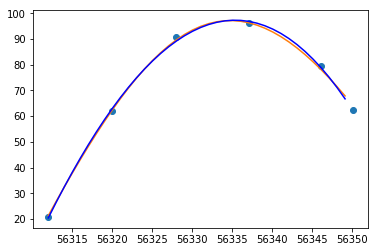

Outlier rejection failed (data: 21.865  model: 22.646  interp: 19.660)
1


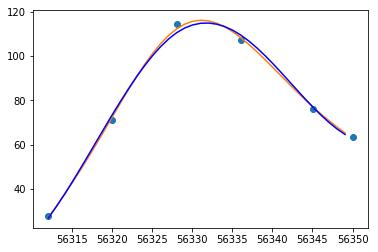

Outlier rejection failed (data: 17.000  model: 12.872  interp: 11.175)
1


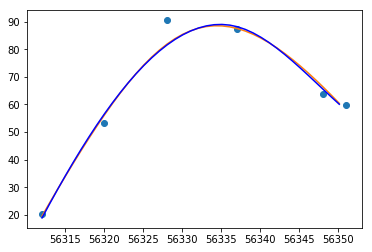

Outlier rejection failed (data: 10.898  model: 12.974  interp: 8.048)
1


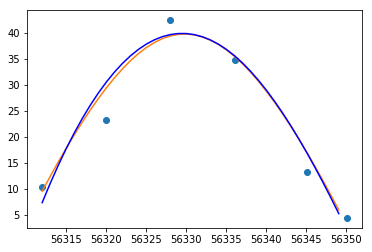

Number of obs in g: 25
Number of obs in i: 24
Number of obs in r: 24
Number of obs in z: 24
dict_keys(['g', 'i', 'r', 'z']) dict_keys(['g', 'i', 'r', 'z'])
Outlier rejection failed (data: 4.417  model: 1.773  interp: 2.237)
22


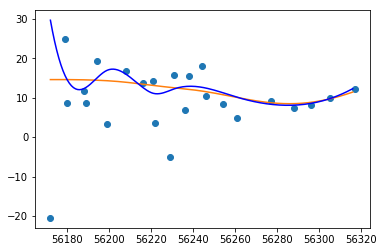

Outlier rejection failed (data: 4.270  model: 5.676  interp: 5.324)
22


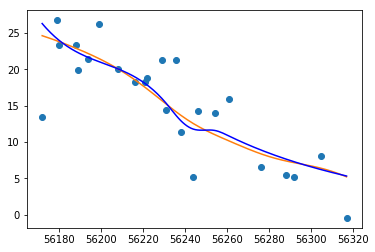

Outlier rejection failed (data: 3.889  model: 1.948  interp: 1.844)
22


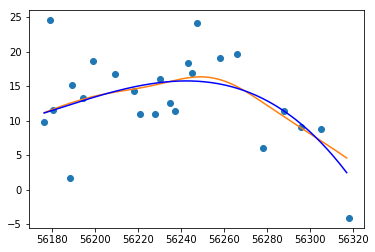

22


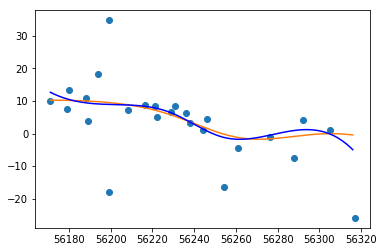

Number of obs in g: 22
Number of obs in i: 22
Number of obs in r: 22
Number of obs in z: 21
dict_keys(['g', 'i', 'r', 'z']) dict_keys(['g', 'i', 'r', 'z'])
32


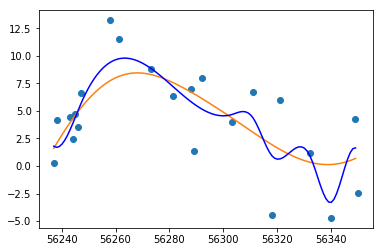

32


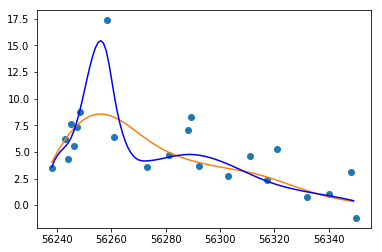

Outlier rejection failed (data: 4.254  model: 4.161  interp: 5.147)
32


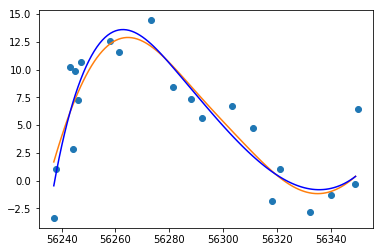

Outlier rejection failed (data: 1.614  model: 1.003  interp: 0.664)
32


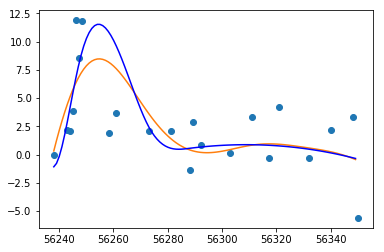

Number of obs in g: 14
Number of obs in i: 14
Number of obs in r: 14
Number of obs in z: 13
dict_keys(['g', 'i', 'r', 'z']) dict_keys(['g', 'i', 'r', 'z'])
Outlier rejection failed (data: 6.599  model: 7.223  interp: 10.055)
33


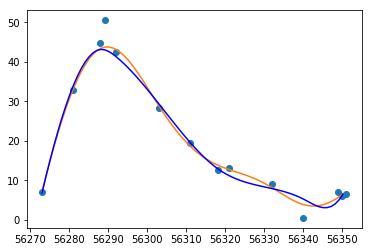

33


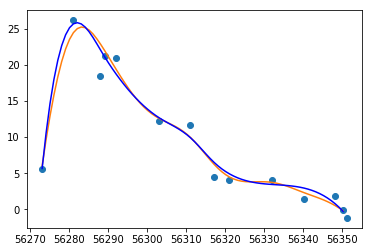

Outlier rejection failed (data: 10.820  model: 10.485  interp: 9.662)
33


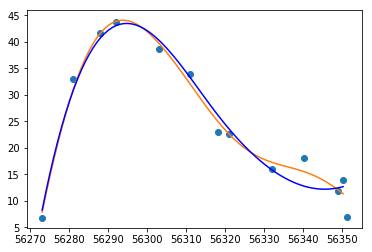

Outlier rejection failed (data: 1.711  model: 0.574  interp: 0.742)
33


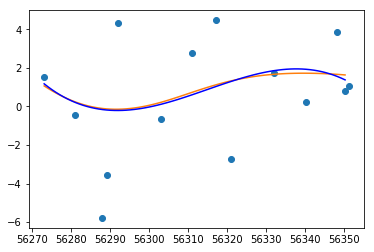

/usr/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-25 20:42:17.817444. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [24]:

lightcurves = os.listdir(base_path)
print(len(lightcurves))
for i,lightcurve in enumerate(lightcurves):
    #Eliminate the three header files
    base_header = 'DES_BLIND+HOSTZ'
    if lightcurve in [base_header+'.README', base_header+'.IGNORE',base_header+'.LIST']:
        continue
    
    tobj = ANTARES_object.TouchstoneObject.fromfile(base_path + lightcurve)
    
    mwebv = tobj.header['mwebv']
    
    object_key = SN_key[int(tobj.objectname)]
    
    sntype = object_key['sntype']
    confirm_type = object_key['confirm_type']
    hostz = object_key['hostz']
    hostzerr = object_key['hostzerr']
    genz = object_key['genz']
    
    
    outbspline = tobj.spline_smooth(per = False, minobs = 6)
    outgp = tobj.gaussian_process_alt_smooth(per = False, scalemin=np.log(10**-4), scalemax=np.log(10**5), minobs=6)
    outjson = {}

    #Only loop over filters that both outgp and outbspline share
    #print("OutGP: ", list(outgp.keys()))
    #print("OutBspline: ", list(outbspline.keys()))
    print(outgp.keys(),outbspline.keys())
    outfilters = list(set(outgp.keys()) & set(outbspline.keys()))
    if set(outgp.keys()) != set(outbspline.keys()):
        print("Filter difference between bspline and GP")

    #Should I do bandMapping right here and head off all future difficulties?

    for filt in outfilters:

        # Generate resampled values from the Gaussian Process regression
        thisgp, thisjd, thismag, thisdmag = outgp[filt]
        mod_dates = np.arange(thisjd.min(), thisjd.max(), 1.)
        thismod, modcovar = thisgp.predict(thismag, mod_dates)
        thismody, modcovary = thisgp.predict(thismag, thisjd)
        thiserr = np.sqrt(np.diag(modcovar))

        # Generate resampled values from the spline model
        thisbspline = outbspline[filt]
        thismod_bspline = scinterp.splev(mod_dates, thisbspline)

        goodstatus = True

        mad_test = np.median(np.abs(thismody - np.median(thismody)))
        mad_mod  = np.median(np.abs(thismod  - np.median(thismod )))
        mad_data = np.median(np.abs(thismag  - np.median(thismag )))

        if (mad_test - mad_data) > 0.5 or np.abs(mad_mod - mad_data) > 0.5:
            goodstatus=False
            message = 'Outlier rejection failed (data: %.3f  model: %.3f  interp: %.3f)'%(mad_data, mad_test, mad_mod)
            print(message)

        outjson[filt] = {'kernel':list(thisgp.kernel.pars),\
                            'mjd':thisjd.tolist(),\
                            'mag':thismag.tolist(),\
                            'dmag':thisdmag.tolist(),\
                            'modeldate':mod_dates.tolist(),\
                            'modelmag':thismod.tolist(),\
                            'modelerr':thiserr.tolist(),\
                            'bsplinemag':thismod_bspline.tolist(),\
                            'goodstatus':goodstatus,\
                            'hostz': hostz,\
                            'hostzerr': hostzerr,\
                            'confirm_type': confirm_type,\
                            'type': sntype}
        #kernelpars.append(thisgp.kernel.pars[0])
        print(sntype)
        plt.plot(thisjd, thismag,'o')
        plt.plot(mod_dates, thismod)
        plt.plot(mod_dates, thismod_bspline,'b')
        plt.show()
    
    if i > 2:
        break

In [12]:
lcurve = t.gaussian_process_alt_smooth(per = False, scalemin=np.log(10**-4), scalemax=np.log(10**5), minobs=6)

Number of obs in g: 6
Number of obs in i: 6
Number of obs in r: 6
Number of obs in z: 6


/usr/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-24 10:26:46.655550. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


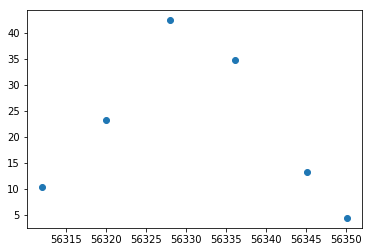

/usr/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-24 10:27:27.872027. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [20]:
mag = lcurve['g'][2]
mjd = lcurve['g'][1]
plt.plot(mjd, mag, 'o')
plt.show()